In [1]:
!pip install convkan
!pip install torchsummary

  Preparing metadata (setup.py) ... - done
  Created wheel for convkan: filename=convkan-0.0.1.2-py3-none-any.whl size=12511 sha256=46a78cf18b1d798655be27ae2cb3da46afd87a868a99fb87e64fb417782d14a3
  Stored in directory: /root/.cache/pip/wheels/b3/72/5f/37f32f7b0865ae5af6efe11d87264e8354ff0fea941fb7e9e6
Successfully built convkan


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt 
from torchsummary import summary

In [3]:
# KANLinear definition Soure: https://github.com/Blealtan/efficient-kan/blob/f39e5146af34299ad3a581d2106eb667ba0fa6fa/src/efficient_kan/kan.py#L6
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=7,
        spline_order=5,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

In [4]:
# CNN model for CIFAR-10 with KANLinear
class CNNKAN(nn.Module):
    def __init__(self):
        super(CNNKAN, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(4)  # Corrected to match the output channels of conv1
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(8)  # Corrected to match the output channels of conv2
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(16)  # Corrected to match the output channels of conv3
        self.pool3 = nn.MaxPool2d(2)
        
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(32)  # Corrected to match the output channels of conv3
        self.pool4 = nn.MaxPool2d(2)
        
        self.kan1 = KANLinear(32 * 20 * 20, 64)
        self.kan2 = KANLinear(64, 128)
        self.kan3 = KANLinear(128, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.selu(self.batchnorm1(x))
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.selu(self.batchnorm2(x))
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.selu(self.batchnorm3(x))
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = F.selu(self.batchnorm4(x))
        x = self.pool4(x)
        
        x = x.view(x.size(0), -1)
        x = self.kan1(x)
        x = self.kan2(x)
        x = self.kan3(x)
        return x
        
    #def forward(self, x):
    #    x = F.selu(self.conv1(x)) #
    #    x = self.batchnorm1(x) #
    #    x = self.pool1(x) #
    #    x = F.selu(self.conv2(x)) #
    #    x = self.batchnorm2(x) #
    #    x = self.pool2(x) #
    #    x = F.selu(self.conv3(x)) #
    #    x = self.batchnorm3(x) #
    #    x = self.pool3(x)
    #    x = x.view(x.size(0), -1)
    #    x = self.kan1(x)
    #    x = self.kan2(x)
    #    return x

In [5]:
def print_parameter_details(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            params = parameter.numel()  # Number of elements in the tensor
            total_params += params
            print(f"{name}: {params}")
    print(f"Total trainable parameters: {total_params}") 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CNN().to(device) 

# Uncommnet this line for CNN KAN. 
model = CNNKAN().to(device) 
print(model) 
print_parameter_details(model)
summary(model,  input_size=(3, 320, 320))

CNNKAN(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, pad

In [7]:
# Note the this is just a rough demo for Visualization. Need modifcation. 
def visualize_kan_parameters(kan_layer, layer_name):
    base_weights = kan_layer.base_weight.data.cpu().numpy()
    plt.hist(base_weights.ravel(), bins=50)
    plt.title(f"Distribution of Base Weights - {layer_name}")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.show()
    if hasattr(kan_layer, 'spline_weight'):
        spline_weights = kan_layer.spline_weight.data.cpu().numpy()
        plt.hist(spline_weights.ravel(), bins=50)
        plt.title(f"Distribution of Spline Weights - {layer_name}")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        plt.show()

In [8]:
for name, param in model.named_parameters():
    print(f"{name}: {param.size()} {'requires_grad' if param.requires_grad else 'frozen'}")

# TODO: Need to explore various Optimizer and optimize the Learning Rate.
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  
])

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
train_dataset = datasets.ImageFolder(root='/kaggle/input/wildfire-prediction-dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/wildfire-prediction-dataset/valid', transform=transform)
test_dataset = datasets.ImageFolder(root='/kaggle/input/wildfire-prediction-dataset/test', transform=transform)

conv1.weight: torch.Size([4, 3, 3, 3]) requires_grad
conv1.bias: torch.Size([4]) requires_grad
batchnorm1.weight: torch.Size([4]) requires_grad
batchnorm1.bias: torch.Size([4]) requires_grad
conv2.weight: torch.Size([8, 4, 3, 3]) requires_grad
conv2.bias: torch.Size([8]) requires_grad
batchnorm2.weight: torch.Size([8]) requires_grad
batchnorm2.bias: torch.Size([8]) requires_grad
conv3.weight: torch.Size([16, 8, 3, 3]) requires_grad
conv3.bias: torch.Size([16]) requires_grad
batchnorm3.weight: torch.Size([16]) requires_grad
batchnorm3.bias: torch.Size([16]) requires_grad
conv4.weight: torch.Size([32, 16, 3, 3]) requires_grad
conv4.bias: torch.Size([32]) requires_grad
batchnorm4.weight: torch.Size([32]) requires_grad
batchnorm4.bias: torch.Size([32]) requires_grad
kan1.base_weight: torch.Size([64, 12800]) requires_grad
kan1.spline_weight: torch.Size([64, 12800, 12]) requires_grad
kan1.spline_scaler: torch.Size([64, 12800]) requires_grad
kan2.base_weight: torch.Size([128, 64]) requires_gr

In [9]:
def get_subset(dataset, percentage):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)  # Shuffle indices to get random subset
    subset_size = int(np.floor(percentage * dataset_size))
    subset_indices = indices[:subset_size]
    return Subset(dataset, subset_indices)

# train_subset = get_subset(train_dataset, 0.1)  # Take 10% of the training dataset
# val_subset = get_subset(val_dataset, 0.1)  # Take 10% of the validation dataset
# test_subset = get_subset(test_dataset, 0.1)  # Take 10% of the test dataset

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

val_losses, test_losses = [], []
def evaluate(model, device, test_loader, loss_list, acc_list):
    model.eval()
    test_loss = 0
    correct = 0
    #with torch.no_grad():
    #    for data, target in val_loader:
    #       data, target = data.to(device), target.to(device)
    #        output = model(data)
    #       val_loss += nn.CrossEntropyLoss()(output, target).item()
    #       pred = output.argmax(dim=1, keepdim=True)
    #       correct += pred.eq(target.view_as(pred)).sum().item()
    #al_loss /= len(test_loader.dataset)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    loss_list.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    acc_list.append(acc)
    
    #rint(f'\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n')
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

val_losses = []
test_losses = []
val_accs = []
test_accs = []
for epoch in range(20):
    train(model, device, train_loader, optimizer, epoch)
    evaluate(model, device, val_loader, val_losses, val_accs)
    evaluate(model, device, test_loader, test_losses, test_accs)
    
torch.save(model.state_dict(), 'model_weights_KAN.pth')

Train Epoch: 0 [0/30250 (0%)]	Loss: 0.687395
Train Epoch: 0 [2560/30250 (8%)]	Loss: 0.347357
Train Epoch: 0 [5120/30250 (17%)]	Loss: 0.265053
Train Epoch: 0 [7680/30250 (25%)]	Loss: 0.238934
Train Epoch: 0 [10240/30250 (34%)]	Loss: 0.230724
Train Epoch: 0 [12800/30250 (42%)]	Loss: 0.177756
Train Epoch: 0 [15360/30250 (50%)]	Loss: 0.247699
Train Epoch: 0 [17920/30250 (59%)]	Loss: 0.186087
Train Epoch: 0 [20480/30250 (67%)]	Loss: 0.200751
Train Epoch: 0 [23040/30250 (76%)]	Loss: 0.195439
Train Epoch: 0 [25600/30250 (84%)]	Loss: 0.190022
Train Epoch: 0 [28160/30250 (92%)]	Loss: 0.214941

Test set: Average loss: 0.0006, Accuracy: 5947/6300 (94%)


Test set: Average loss: 0.0005, Accuracy: 6004/6300 (95%)

Train Epoch: 1 [0/30250 (0%)]	Loss: 0.187326
Train Epoch: 1 [2560/30250 (8%)]	Loss: 0.212695
Train Epoch: 1 [5120/30250 (17%)]	Loss: 0.131092
Train Epoch: 1 [7680/30250 (25%)]	Loss: 0.155466
Train Epoch: 1 [10240/30250 (34%)]	Loss: 0.184529
Train Epoch: 1 [12800/30250 (42%)]	Loss: 0.18258

In [10]:
print(val_accs)
print(test_accs)
print(val_losses)
print(test_losses)

[94.39682539682539, 94.39682539682539, 95.38095238095238, 96.01587301587301, 96.11111111111111, 96.26984126984127, 96.22222222222223, 96.3015873015873, 96.38095238095238, 96.68253968253968, 96.47619047619048, 96.4920634920635, 96.63492063492063, 96.44444444444444, 96.52380952380952, 96.60317460317461, 95.9047619047619, 96.17460317460318, 96.39682539682539, 96.87301587301587]
[95.3015873015873, 95.11111111111111, 96.01587301587301, 96.71428571428571, 96.80952380952381, 96.84126984126983, 96.85714285714286, 96.73015873015873, 96.98412698412699, 97.12698412698413, 97.17460317460318, 96.98412698412699, 97.22222222222223, 96.95238095238095, 97.12698412698413, 97.11111111111111, 96.41269841269842, 96.7936507936508, 96.63492063492063, 97.31746031746032]
[0.0006031747759571151, 0.0005713390703830454, 0.0004903868375907814, 0.0004368745174909395, 0.0004205399225392039, 0.0004116917983998382, 0.0004070246521206129, 0.0004263793100558576, 0.00041080632764432166, 0.0004085583842936016, 0.000416385

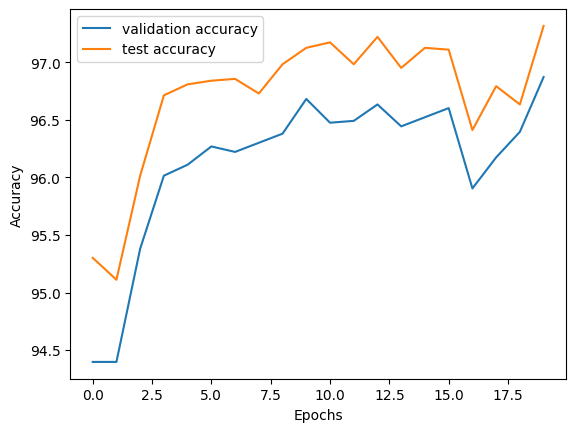

In [11]:
plt.plot(val_accs, label = 'validation accuracy')
plt.plot(test_accs, label = 'test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(95.1, 98)
plt.legend()

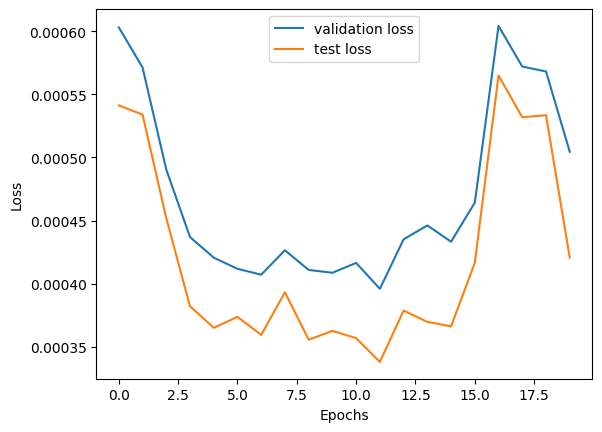

In [12]:
plt.plot(val_losses, label = 'validation loss')
plt.plot(test_losses, label = 'test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [13]:
from sklearn.metrics import classification_report

# Load the trained model if you have saved it previously
# model = CNNKAN().to(device)
# model.load_state_dict(torch.load('model_weights_KAN.pth'))
# model.eval()  # Set the model to evaluation mode

def evaluate(model, device, test_loader, all_preds=None, all_targets=None):
    model.eval()
    preds = []
    targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            preds.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    
    if all_preds is not None and all_targets is not None:
        all_preds.extend(preds)
        all_targets.extend(targets)

# Prepare to store predictions and targets for classification report
all_preds = []
all_targets = []

# Evaluate the model on the test set
evaluate(model, device, test_loader, all_preds=all_preds, all_targets=all_targets)

# Generate classification report for the test set
print(classification_report(all_targets, all_preds, target_names=[str(i) for i in range(2)]))  # Assuming CIFAR-10 has 10 classes

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2820
           1       0.98      0.97      0.98      3480

    accuracy                           0.97      6300
   macro avg       0.97      0.97      0.97      6300
weighted avg       0.97      0.97      0.97      6300



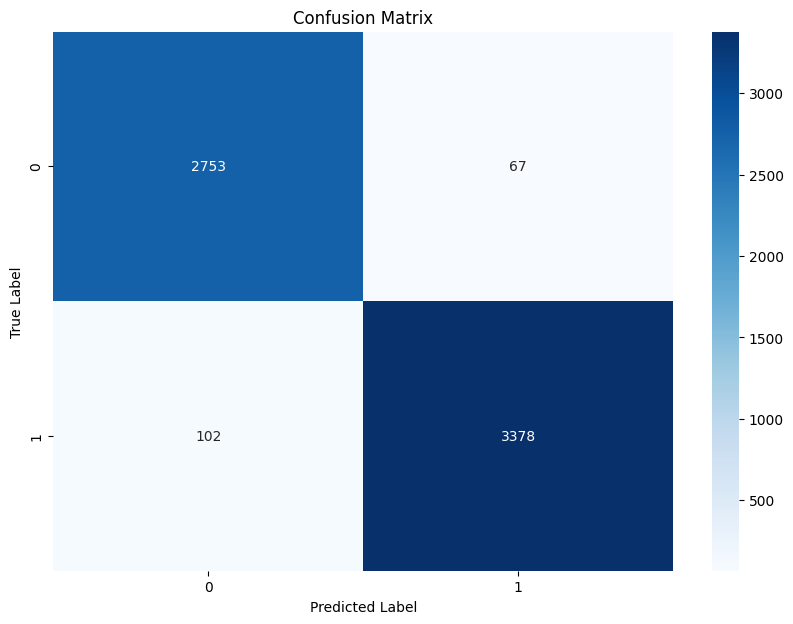

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assume `all_preds` and `all_targets` are already populated from the evaluate function
# If not, you can run the evaluate function again as shown earlier.

# Generate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[str(i) for i in range(2)], yticklabels=[str(i) for i in range(2)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

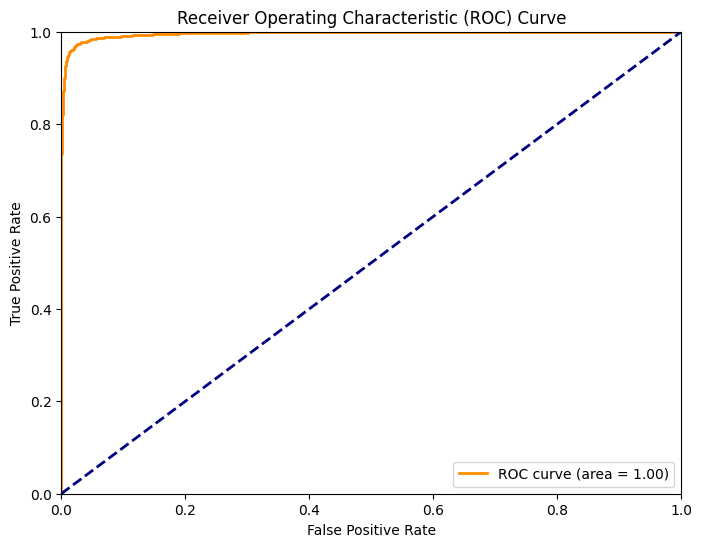

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 1: Get true labels and predicted probabilities from the model
all_targets = []  # True labels
all_probs = []    # Predicted probabilities for the positive class

# Collect true labels and predicted probabilities
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        probs = torch.softmax(output, dim=1)  # Convert logits to probabilities
        # Get the probability for class 1 (positive class in binary classification)
        positive_class_probs = probs[:, 1]
        all_targets.append(target.cpu().numpy())
        all_probs.append(positive_class_probs.cpu().numpy())

# Step 2: Concatenate the results to get the full dataset
all_targets = np.concatenate(all_targets)
all_probs = np.concatenate(all_probs)

# Step 3: Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

# Step 4: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

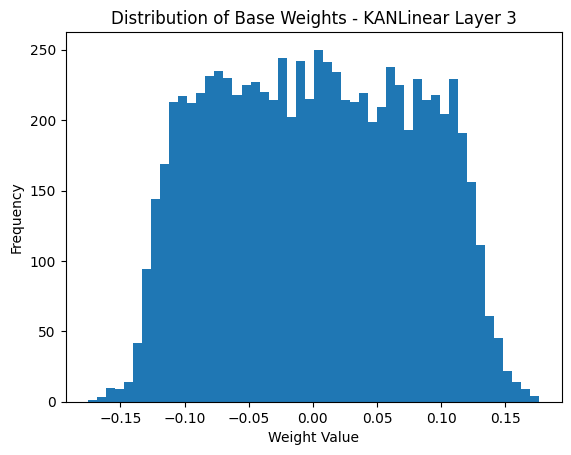

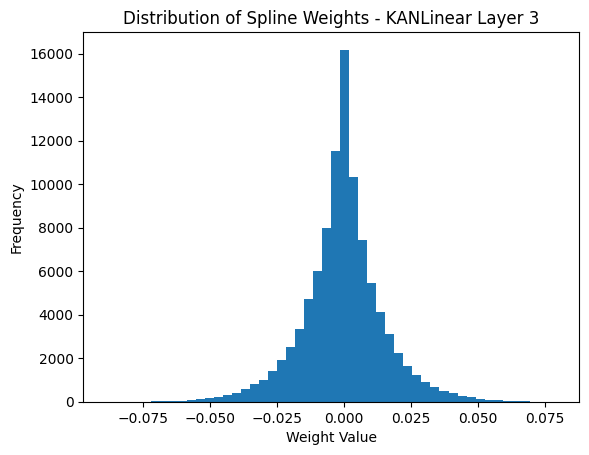

In [16]:
# Training complete or loaded model weights

# Move model to CPU if necessary
model.to('cpu')

# Visualize parameters of the last KANLinear layer (kan3)
visualize_kan_parameters(model.kan2, 'KANLinear Layer 3')